# assignment_1b question 1

# Table of Contents <a name="toc"></a>

* [Imports](#imports)
* [Global](#global)
* [Helper Functions](#helper_functions)
* [Question 1: Convergence](#convergence)
    * [Model Parameters](#model_parameters)
    * [Create the Model](#create_the_model)
    * [Run the Model](#run_the_model)
    * [Save and Load Data Objects](#save_and_load_data_objects)
    * [Plot Model Performance](#plot_model_performance)
    * [Comparing Models](#comparing_models)
    * [Eyeballing Convergence](#eyeballing_convergence)
    * [Try Test Set](#try_test_set)
* [Conclusion](#conclusion)

# Imports <a name="imports"></a> 
[Back to top](#toc)

In [113]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import json

from tensorflow import keras
from tqdm.keras import TqdmCallback
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [114]:
X_train = np.load('data/X_train.npy')
X_test = np.load('data/X_test.npy')
Y_train = np.load('data/Y_train.npy')
Y_test = np.load('data/Y_test.npy')
print("Data loaded")

Data loaded


# Global <a name="global"></a> 
[Back to top](#toc)

In [115]:
seed = 10
np.random.seed(seed)
tf.random.set_seed(seed)

# data objects
histories = {}

# Helper Functions <a name="helper_functions"></a> 
[Back to top](#toc)

### histories_saver()

In [116]:
# filename like 'data/q0_histories.json'
def histories_saver(histories, filename, already_json=False):
    histories_json = {}
    
    if already_json:
        histories_json = histories
    else:
        for key in histories.keys():
            histories_json[key] = histories[key].history

    with open(filename, 'w') as file:
        json.dump(histories_json, file)

    print("Histories saved")

### histories_loader()

In [117]:
# filename like 'data/q0_histories.json'
def histories_loader(filename):
    with open(filename) as json_file:
        histories = json.load(json_file)
    print('Histories loaded')
    
    return histories 

### plot_history_object()

In [118]:
def plot_history_object(histories, model_name, history_object, plot_val=True, max=None):    
    if max==None:
        plt.plot(histories[model_name][history_object], label='train_'+history_object)

        if plot_val:
            plt.plot(histories[model_name]['val_'+history_object], label='val_'+history_object)
    else:
        plt.plot(histories[model_name][history_object][:max], label='train_'+history_object)

        if plot_val:
            plt.plot(histories[model_name]['val_'+history_object][:max], label='val_'+history_object)
            
    plt.title(history_object + ' against epochs')
    plt.ylabel(history_object)
    plt.xlabel('epochs')
    plt.legend(loc="center right")
    plt.show()

### TestCallback()

In [119]:
# custom callback to evaluate the test set at each epoch
class TestCallback(keras.callbacks.Callback):
    def __init__(self, X_test, Y_test):
        self.X_test = X_test
        self.Y_test = Y_test

    def on_epoch_end(self, epoch, logs={}):
        loss, mse = self.model.evaluate(self.X_test, self.Y_test, verbose=0)
        
        histories_test['test_values']['mse'].append(mse)
        histories_test['test_values']['loss'].append(loss)

# Question 1: Convergence  <a name="convergence"></a>
[Back to top](#toc)

<i>Design a 3-layer feedforward neural network consists of an input layer, a hidden-layer of 10 neurons having ReLU activation functions, and a linear output layer. Use mini-batch gradient descent with a batch size = 8, 𝐿2 regularization at weight decay parameter 𝛽 = 10−3 and a learning rate 𝛼 = 10−3 to train the network.

* a) Use the train dataset to train the model and plot both the train and test errors against epochs.
* b) State the approximate number of epochs where the test error is minimum and use it to stop training.
* c) Plot the predicted values and target values for any 50 test samples.</i>

### Model Parameters <a name="model_parameters"></a> 
[Back to top](#toc)

Loss function of choice is ```keras.losses.MeanSquaredError()```

This loss function is for a regression problem

In [120]:
num_neurons = 10

weight_decay_parameter = 10e-3
regularization = keras.regularizers.l2(weight_decay_parameter)

learning_rate= 10e-3
optimizer = keras.optimizers.SGD(learning_rate=learning_rate)

loss = keras.losses.MeanSquaredError()
metrics = ['mse']

validation_split = 0.3
epochs = 500
batch_size = 8

callbacks = [TqdmCallback(verbose=1)]

print("Model Parameters set")

Model Parameters set


### Create the model <a name="create_the_model"></a> 
[Back to top](#toc)

In [121]:
def create_model(num_neurons, regularization, optimizer, loss, metrics):
    model = keras.Sequential([
        keras.layers.Dense(num_neurons, activation='relu', kernel_regularizer=regularization),
        keras.layers.Dense(1, activation='linear')
    ])
    
    model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)
    
    print("Model created")
    return model

In [122]:
def fit_model(X_train, Y_train, model_name, model, validation_split, epochs, batch_size, callbacks):
    print("Training ", model_name)
    
    history = model.fit(X_train, Y_train,
                            validation_split=validation_split,
                            epochs=epochs,
                            batch_size=batch_size,  
                            callbacks=callbacks,
                            verbose = 0)    
                            
    return model, history

### Run the model <a name="run_the_model"></a> 
[Back to top](#toc)

In [123]:
model = create_model(num_neurons, regularization, optimizer, loss, metrics)
model_name = 'convergence_train'

# create a new time_callback for every run
callbacks = [TqdmCallback(verbose=1)]

model_convergence_train, histories[model_name] = fit_model(X_train, Y_train, model_name, model, validation_split, epochs, batch_size, callbacks)

Model created


Training  convergence_train




### Save and Load Data Objects <a name="save_and_load_data_objects"></a> 
[Back to top](#toc)

In [124]:
histories_saver(histories, "data/q1_histories.json")

histories = histories_loader("data/q1_histories.json")

Histories saved
Histories loaded


### Plot Model Performance <a name="plot_model_performance"></a> 
[Back to top](#toc)

Model:  convergence_train


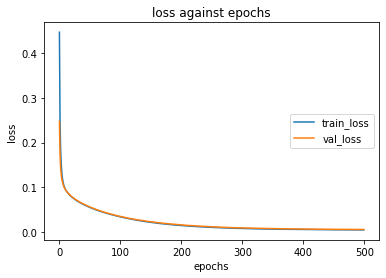

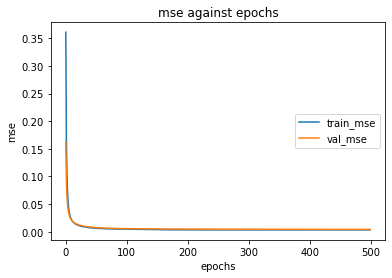

In [125]:
for model_name in histories.keys():
    print('Model: ', model_name)
    for history_object in ['loss', 'mse']:
        plot_history_object(histories, model_name, history_object)

### Comparing Models <a name="comparing_models"></a> 
[Back to top](#toc)

<b>loss (regularized) vs mse</b>

We can see that while the ```loss``` (regularized) takes about 300 epochs to reach convergence, the ```mse``` already has achieved convergence well before 100 epochs. This is largely due to the penalty of regularization on the loss

However, graphs looked a little zoomed out. Let's zoom in

Model:  convergence_train


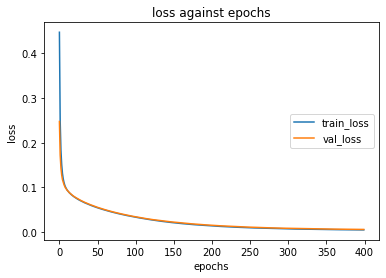

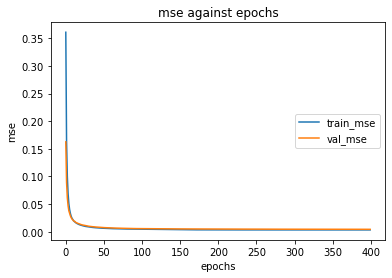

In [126]:
for model_name in histories.keys():
    print('Model: ', model_name)
    for history_object in ['loss', 'mse']:
        plot_history_object(histories, model_name, history_object, max=400)

### Eyeballing Convergence <a name="eyeballing_convergence"></a> 
[Back to top](#toc)

> It appears that ```epochs=400``` is sufficient to achieve convergence for the loss

### Try Test Set <a name="try_test_set"></a> 
[Back to top](#toc)

We shall use ```epochs=400``` to check the performance of the model on the test set

In [127]:
# the optimized parameter and custome callback
epochs = 400
callbacks = [TqdmCallback(verbose=1), TestCallback(X_test, Y_test)] 

# the history object to keep performance of X_test Y_test from hinal model
histories_test = {
    'test_values': {
        'loss': [],
        'mse': []
    }
}

# the history object to keep performance of X_train Y_train from final model
histories_final = {}

In [128]:
model = create_model(num_neurons, regularization, optimizer, loss, metrics)
model_name = 'train_values'
model_convergence_test, histories_final[model_name] = fit_model(X_train, Y_train, model_name, model, validation_split, epochs, batch_size, callbacks)

# the history
histories_saver(histories_final, "data/q1_histories_final.json")
histories_final = histories_loader("data/q1_histories_final.json")

histories_final['test_values'] = histories_test['test_values']

histories_saver(histories_final, "data/q1_histories_final.json", already_json=True)
histories_final = histories_loader("data/q1_histories_final.json")

Model created
Training  train_values

Histories saved
Histories loaded
Histories saved
Histories loaded


> ### a) Use the train dataset to train the model and plot both the train and test errors against epochs

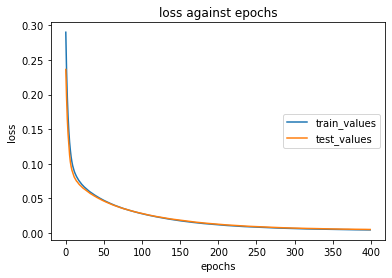

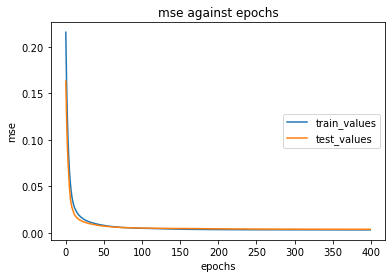

In [129]:
for history_object in ['loss', 'mse']:
    for model_name in histories_final.keys():
        plt.plot(histories_final[model_name][history_object], label=model_name)

    plt.title(history_object + ' against epochs')
    plt.ylabel(history_object)
    plt.xlabel('epochs')
    plt.legend(loc="center right")
    plt.show()

# Conclusion <a name="conclusion"></a> 
[Back to top](#toc)

> ### b) State the approximate number of epochs where the test error begin to converge

> 400 epochs appears to be more than sufficient to get a reasonable convergence 

> ### c) Plot the predicted values and target values for any 50 test samples.

In [130]:
Y_test_pred = model_convergence_test.predict(X_test)
Y_test_pred = Y_test_pred.reshape(1,120)[0]

In [131]:
df_Y_test_pred = pd.DataFrame(Y_test_pred, columns =['Y_test_pred']) 
df_Y_test = pd.DataFrame(Y_test, columns =['Y_test']) 
df_scatter_y_test_pred = pd.concat([df_Y_test_pred, df_Y_test], axis=1)

In [132]:
df_scatter_y_test_pred = df_scatter_y_test_pred.sample(n=50, random_state=seed)
scatter_index = df_scatter_y_test_pred.index
print(scatter_index)
df_scatter_y_test_pred.head()

Int64Index([ 45,  79,  56,  85,  99,  41,  81, 110,  48,   2,  53,  52,  94,
             43,  80,   1,  10,  35,  47,  26,  68,  82,  37,  19,  14,  39,
             38,  63, 104, 111,   3,  75,  70, 108,  97, 115, 116,  67,  61,
             83,  84,  91,  76,  42,  21,   6,  95, 112, 103,  71],
           dtype='int64')


,Y_test_pred,Y_test
45,0.741714,0.77
79,0.536456,0.44
56,0.728814,0.75
85,0.646655,0.62
99,0.659853,0.50


##### First view: plotting pred+ground_truth pairs

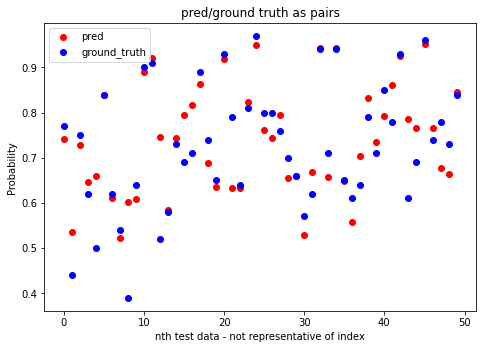

In [133]:
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(np.arange(50), df_scatter_y_test_pred['Y_test_pred'], color='r', label='pred')
ax.scatter(np.arange(50), df_scatter_y_test_pred['Y_test'], color='b', label='ground_truth')
ax.set_title('pred/ground truth as pairs')
ax.set_xlabel('nth test data - not representative of index')
ax.set_ylabel('Probability')
ax.legend()
plt.show()

##### Second view: predicted value against ground truth

If a datapoint lies on the y=x line, it represents a perfect prediction

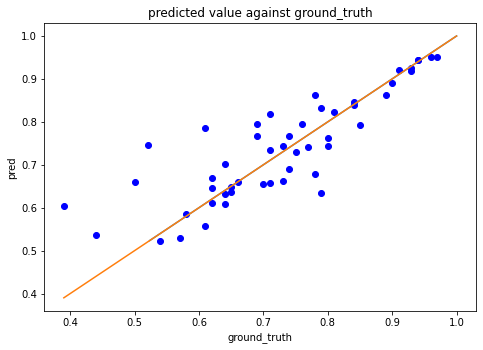

In [134]:
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(df_scatter_y_test_pred['Y_test'], df_scatter_y_test_pred['Y_test_pred'], color='b')
ax.plot(np.linspace(np.min(df_scatter_y_test_pred),1,100),np.linspace(np.min(df_scatter_y_test_pred),1,100))
ax.set_title('predicted value against ground_truth')
ax.set_xlabel('ground_truth')
ax.set_ylabel('pred')
plt.show()